<a href="https://colab.research.google.com/github/moridin04/CCRNFLRL_PROJECT_COM221ML/blob/main/Hangman-DQN-Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade --pre "gymnasium[atari]" ale-py

import random
import numpy as np
import gymnasium as gym #Hangman Environment
import ale_py
import torch #Neural Networks
import torch.nn as nn
import torch.optim as optim
from collections import deque #Replay Buffer
import matplotlib.pyplot as plt
import imageio
from IPython.display import Video
import cv2
import random
import time
from skimage import transform
import tensorflow as tf
from skimage.color import rgb2gray
import base64
from IPython.display import HTML

In [2]:
class FrameStack:
    def __init__(self, stack_size=4):
        self.stack_size = stack_size
        self.frames = deque(maxlen=stack_size)

    def reset(self, state):
        """Reset with initial state"""
        self.frames.clear()
        for _ in range(self.stack_size):
            self.frames.append(state)
        return self.get_stacked_frames()

    def append(self, state):
        """Add new frame and return stacked frames"""
        self.frames.append(state)
        return self.get_stacked_frames()

    def get_stacked_frames(self):
        """Return stacked frames as single array with channels first"""
        stacked = np.stack(self.frames, axis=0)  # Shape: (stack_size, 84, 84)
        return stacked

In [3]:
def preprocess_state(state):
    """Proper Atari frame preprocessing for Hangman"""
    if isinstance(state, np.ndarray) and len(state.shape) == 3:
        # Convert to grayscale, resize to 84x84, normalize
        state = cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)
        state = cv2.resize(state, (84, 84))
        state = state.astype(np.float32) / 255.0
        return state
    else:
        # Handle discrete state case
        state_size = 100
        vec = np.zeros(state_size)
        vec[state] = 1.0
        return vec

In [4]:
def record_episode(env, q_net, preprocess_state, episode_num, max_steps=200):
    """Record a video of the agent playing one episode with tie-breaking"""
    frames = []
    state, _ = env.reset()

    # Use frame stacking for recording too
    frame_stack = FrameStack()
    state_processed = frame_stack.reset(preprocess_state(state))

    total_reward = 0
    done = False
    step_count = 0
    previously_guessed = set()

    # Record initial state
    frames.append(env.render())

    while not done and step_count < max_steps:
        step_count += 1

        # Agent's action with tie-breaking noise
        with torch.no_grad():
            # Reshape for convolutional network (batch_size, channels, height, width)
            state_tensor = torch.FloatTensor(state_processed).unsqueeze(0)  # Add batch dimension
            q_values = q_net(state_tensor)
            # Add small random noise to break ties in Q-values
            noise = torch.randn_like(q_values) * 0.1
            action = torch.argmax(q_values + noise).item()

        # Avoid repeating the same action if possible
        if action in previously_guessed:
            # Try to find an unguessed action
            sorted_actions = torch.argsort(q_values + noise, descending=True)
            for alt_action in sorted_actions[0]:
                alt_action = alt_action.item()
                if alt_action not in previously_guessed:
                    action = alt_action
                    break

        previously_guessed.add(action)
        state, reward, terminated, truncated, _ = env.step(action)
        state_processed = frame_stack.append(preprocess_state(state))
        done = terminated or truncated
        total_reward += reward

        # Record frame
        frames.append(env.render())

        if done:
            break

    # Save as video
    filename = f"hangman_episode_{episode_num}_reward_{total_reward:.1f}.mp4"
    with imageio.get_writer(filename, fps=5) as writer:
        for frame in frames:
            writer.append_data(frame)

    return filename, total_reward, step_count

In [5]:
def show_video(video_path):
    """Display video in notebook"""
    try:
        video_file = open(video_path, "r+b").read()
        video_url = f"data:video/mp4;base64,{base64.b64encode(video_file).decode()}"
        return HTML(f"""<video width="600" controls><source src="{video_url}"></video>""")
    except FileNotFoundError:
        print(f"Video file {video_path} not found")
        return HTML("<p>Video not available</p>")

In [6]:
def test_reward_structure():
    env = gym.make("ALE/Hangman-v5", render_mode="rgb_array")
    state, _ = env.reset()

    print("Testing reward structure...")
    print(f"Action space: {env.action_space}")
    print(f"Action meanings: 0-25 are letters A-Z, 26 is guess word, 27 is new game")

    # Test a few actions to see rewards
    for action in [0, 1, 2]:  # Test letters A, B, C
        next_state, reward, terminated, truncated, info = env.step(action)
        print(f"Action {action}: Reward = {reward}, Done = {terminated or truncated}")

        if terminated or truncated:
            state, _ = env.reset()

    env.close()

In [7]:
def smart_exploration(action_size, previously_guessed=None, step_count=0):
    """Pure random exploration - let the CNN learn from visual patterns"""
    return random.randint(0, action_size - 1)

In [8]:
# Convolutional Deep Q-Network for Atari
class ConvDQN(nn.Module):
    def __init__(self, action_size, stack_size=4):
        super(ConvDQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(stack_size, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        # Calculate the size after convolutions
        self.fc_input_size = self._get_conv_output((stack_size, 84, 84))

        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, action_size)
        )

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0.1)

    def _get_conv_output(self, shape):
        with torch.no_grad():
            input = torch.zeros(1, *shape)
            output = self.conv(input)
            return int(np.prod(output.size()))

    def forward(self, x):
        # x shape: (batch_size, stack_size, 84, 84)
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

In [9]:
#Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)
    def add(self, experience):
        self.buffer.append(experience)
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards, dtype=np.float32),
                np.array(next_states), np.array(dones, dtype=np.uint8))

    def __len__(self):
        return len(self.buffer)

In [10]:
def train_dqn(episodes=500,  # Reduced for testing
              gamma=0.99,
              lr=0.00025,
              batch_size=32,
              epsilon_decay=0.995,
              min_epsilon=0.01,
              buffer_size=10000,
              stack_size=4):

    env = gym.make("ALE/Hangman-v5", render_mode="rgb_array")

    # Test the actual observation
    state, _ = env.reset()
    print(f"Original state shape: {state.shape}")
    print(f"Action space: {env.action_space.n}")

    action_size = env.action_space.n

    # Initialize networks
    q_net = ConvDQN(action_size, stack_size)
    target_net = ConvDQN(action_size, stack_size)
    target_net.load_state_dict(q_net.state_dict())

    optimizer = optim.Adam(q_net.parameters(), lr=lr, eps=1e-8)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

    memory = ReplayBuffer(buffer_size)
    frame_stack = FrameStack(stack_size)
    epsilon = 1.0
    rewards_all = []
    wins = 0
    total_steps = 0

    # PRE-FILLING WITH FRAME STACKING
    print("Pre-filling replay buffer with frame stacking...")
    for _ in range(1000):  # Reduced for testing
        state, _ = env.reset()
        current_frames = frame_stack.reset(preprocess_state(state))
        previously_guessed = set()

        for step in range(15):
            action = random.randint(0, action_size - 1)
            previously_guessed.add(action)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            next_frames = frame_stack.append(preprocess_state(next_state))

            # Enhanced reward shaping for visual learning
            scaled_reward = reward
            if reward > 0:  # Correct guess
                scaled_reward = 5.0 + reward
                if len(previously_guessed) <= 3:
                    scaled_reward += 2.0
            elif reward == 0:  # Wrong guess
                scaled_reward = -0.5
            else:  # Game loss
                scaled_reward = -2.0

            memory.add((current_frames, action, scaled_reward, next_frames, done))
            current_frames = next_frames

            if done:
                break

    print(f"Replay buffer filled with {len(memory)} experiences")

    # TRAINING LOOP
    for ep in range(episodes):
        state, _ = env.reset()
        current_frames = frame_stack.reset(preprocess_state(state))
        total_reward = 0
        done = False
        step_count = 0
        previously_guessed = set()

        while not done:
            step_count += 1
            total_steps += 1

            # Exploration vs Exploitation
            if np.random.rand() < epsilon:
                action = random.randint(0, action_size - 1)
            else:
                with torch.no_grad():
                    # Add batch dimension only (channels are already first)
                    state_tensor = torch.FloatTensor(current_frames).unsqueeze(0)
                    q_values = q_net(state_tensor)
                    noise = torch.normal(0, 0.1, size=q_values.shape)
                    action = torch.argmax(q_values + noise).item()

            action = action % action_size
            previously_guessed.add(action)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_frames = frame_stack.append(preprocess_state(next_state))

            # Reward scaling
            scaled_reward = reward
            if reward > 0:
                scaled_reward = 5.0 + reward
                if len(previously_guessed) <= 3:
                    scaled_reward += 2.0
            elif reward == 0:
                scaled_reward = -0.5
            else:
                scaled_reward = -2.0

            memory.add((current_frames, action, scaled_reward, next_frames, done))
            current_frames = next_frames
            total_reward += reward

            # TRAINING
            if len(memory) > batch_size and total_steps % 4 == 0:
                batch = memory.sample(batch_size)
                states, actions, rewards, next_states, dones = batch

                # Convert to tensors with proper shape for CNN
                states_t = torch.FloatTensor(states)  # Shape: (batch_size, stack_size, 84, 84)
                actions_t = torch.LongTensor(actions).unsqueeze(1)
                rewards_t = torch.FloatTensor(rewards)
                next_states_t = torch.FloatTensor(next_states)
                dones_t = torch.BoolTensor(dones)

                current_q = q_net(states_t).gather(1, actions_t).squeeze()

                with torch.no_grad():
                    next_q = target_net(next_states_t).max(1)[0]
                    target_q = rewards_t + gamma * next_q * (~dones_t).float()

                loss = nn.SmoothL1Loss()(current_q, target_q)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(q_net.parameters(), 1.0)
                optimizer.step()

        # Track wins
        if total_reward > 0:
            wins += 1

        # Update target network
        if ep % 10 == 0:
            target_net.load_state_dict(q_net.state_dict())

        # Update epsilon and learning rate
        epsilon = max(epsilon * epsilon_decay, min_epsilon)
        if ep % 100 == 0:
            scheduler.step()

        rewards_all.append(total_reward)

        # Logging
        if ep % 20 == 0:
            recent_rewards = rewards_all[-20:] if len(rewards_all) >= 20 else rewards_all
            avg_reward = np.mean(recent_rewards)
            recent_wins = sum(1 for r in recent_rewards if r > 0)
            win_rate = (recent_wins / len(recent_rewards)) * 100 if recent_rewards else 0
            current_lr = scheduler.get_last_lr()[0]

            print(f"Episode {ep:4d} | "
                  f"Avg Reward: {avg_reward:7.3f} | "
                  f"Win Rate: {win_rate:5.1f}% | "
                  f"Epsilon: {epsilon:.4f} | "
                  f"LR: {current_lr:.6f} | "
                  f"Steps: {step_count:3d} | "
                  f"Total Wins: {wins:3d}")

    env.close()
    return q_net, rewards_all

In [11]:
# Quick environment test
def test_env():
    env = gym.make("ALE/Hangman-v5", render_mode="rgb_array")
    state, _ = env.reset()
    print(f"State type: {type(state)}, State shape: {state.shape}")
    print(f"Observation space: {env.observation_space}")
    print(f"Action space: {env.action_space}")
    env.close()

test_env()

State type: <class 'numpy.ndarray'>, State shape: (210, 160, 3)
Observation space: Box(0, 255, (210, 160, 3), uint8)
Action space: Discrete(18)


In [12]:
# Test environment behavior
def test_env_behavior():
    env = gym.make("ALE/Hangman-v5", render_mode="rgb_array")
    state, _ = env.reset()
    for i in range(10):  # Test fewer steps
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, info = env.step(action)
        print(f"Step {i}: Action={action}, Reward={reward}, Done={terminated or truncated}")
        if terminated or truncated:
            print("Environment ended early!")
            break
    env.close()

test_env_behavior()

Step 0: Action=16, Reward=0.0, Done=False
Step 1: Action=12, Reward=0.0, Done=False
Step 2: Action=6, Reward=0.0, Done=False
Step 3: Action=6, Reward=0.0, Done=False
Step 4: Action=15, Reward=0.0, Done=False
Step 5: Action=9, Reward=0.0, Done=False
Step 6: Action=5, Reward=0.0, Done=False
Step 7: Action=17, Reward=0.0, Done=False
Step 8: Action=7, Reward=0.0, Done=False
Step 9: Action=6, Reward=0.0, Done=False


In [14]:
test_reward_structure()

print("Starting training with Convolutional DQN...")
q_net, rewards_all = train_dqn(
    episodes=500,
    gamma=0.99,
    lr=0.00025,
    batch_size=32,
    epsilon_decay=0.995,
    min_epsilon=0.01,
    buffer_size=10000
)

Testing reward structure...
Action space: Discrete(18)
Action meanings: 0-25 are letters A-Z, 26 is guess word, 27 is new game
Action 0: Reward = 0.0, Done = False
Action 1: Reward = 0.0, Done = False
Action 2: Reward = 0.0, Done = False
Starting training with Convolutional DQN...
Original state shape: (210, 160, 3)
Action space: 18
Pre-filling replay buffer with frame stacking...
Replay buffer filled with 10000 experiences
Episode    0 | Avg Reward:  -1.000 | Win Rate:   0.0% | Epsilon: 0.9950 | LR: 0.000250 | Steps: 163 | Total Wins:   0
Episode   20 | Avg Reward:  -0.900 | Win Rate:   5.0% | Epsilon: 0.9001 | LR: 0.000250 | Steps: 182 | Total Wins:   1
Episode   40 | Avg Reward:  -1.000 | Win Rate:   0.0% | Epsilon: 0.8142 | LR: 0.000250 | Steps: 172 | Total Wins:   1
Episode   60 | Avg Reward:  -1.000 | Win Rate:   0.0% | Epsilon: 0.7366 | LR: 0.000250 | Steps: 147 | Total Wins:   1
Episode   80 | Avg Reward:  -1.000 | Win Rate:   0.0% | Epsilon: 0.6663 | LR: 0.000250 | Steps: 164 

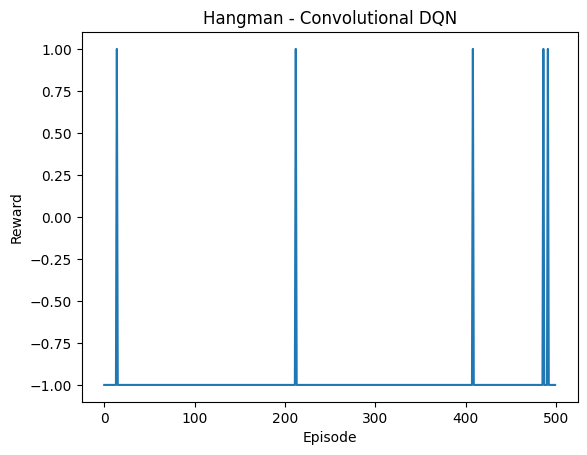

In [15]:
plt.plot(rewards_all)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Hangman - Convolutional DQN")
plt.show()


In [16]:
print(f"\nTraining Statistics:")
print(f"Total episodes: {len(rewards_all)}")
print(f"Average reward: {np.mean(rewards_all):.2f}")
print(f"Max reward: {np.max(rewards_all):.2f}")
print(f"Wins: {sum(1 for r in rewards_all if r > 0)}")


Training Statistics:
Total episodes: 500
Average reward: -0.98
Max reward: 1.00
Wins: 5


In [17]:
print("\n" + "="*50)
print("RECORDING DEMONSTRATION VIDEOS")
print("="*50)

# Create a new environment for recording
record_env = gym.make("ALE/Hangman-v5", render_mode="rgb_array")

# Record episodes at different training stages
episodes_to_record = [0, 100, 200, 300, 400, 500]

for ep_num in episodes_to_record:
    print(f"Recording episode {ep_num}...")
    video_file, final_reward, steps = record_episode(record_env, q_net, preprocess_state, ep_num)
    print(f"Episode {ep_num}: Final Reward = {final_reward}, Steps = {steps}")
    print(f"Video saved as: {video_file}")

    # Display the video
    print("Displaying video:")
    display(show_video(video_file))
    print("-" * 40)

record_env.close()

print("All demonstration videos recorded!")


RECORDING DEMONSTRATION VIDEOS
Recording episode 0...


Episode 0: Final Reward = -1.0, Steps = 175
Video saved as: hangman_episode_0_reward_-1.0.mp4
Displaying video:


----------------------------------------
Recording episode 100...


Episode 100: Final Reward = -1.0, Steps = 168
Video saved as: hangman_episode_100_reward_-1.0.mp4
Displaying video:


----------------------------------------
Recording episode 200...


Episode 200: Final Reward = -1.0, Steps = 177
Video saved as: hangman_episode_200_reward_-1.0.mp4
Displaying video:


----------------------------------------
Recording episode 300...


Episode 300: Final Reward = -1.0, Steps = 180
Video saved as: hangman_episode_300_reward_-1.0.mp4
Displaying video:


----------------------------------------
Recording episode 400...


Episode 400: Final Reward = -1.0, Steps = 168
Video saved as: hangman_episode_400_reward_-1.0.mp4
Displaying video:


----------------------------------------
Recording episode 500...


Episode 500: Final Reward = -1.0, Steps = 161
Video saved as: hangman_episode_500_reward_-1.0.mp4
Displaying video:


----------------------------------------
All demonstration videos recorded!
